# Predicting lung cancer survival time by OWKIN

### Problem

- supervised survival prediction problem
- predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data

### Import

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import autosklearn.regression
import time

# concordance index (C-index)
from metrics_t9gbvr2 import cindex

/home/damien/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Data

- x_train : data_Q0G7b5t
- y_train : output_VSVxRFU.csv
- x_test : data_9Cbe5hx

In [2]:
data_folder_path = "../data"
training_folder_path = os.path.join(data_folder_path, "data_Q0G7b5t")
test_folder_path = os.path.join(data_folder_path, "data_9Cbe5hx")

training_ct_scan_names = [os.path.join(root,file_name) for root,_,file_names in os.walk(training_folder_path) for file_name in file_names if file_name.endswith('.npz')]
test_ct_scan_names = [os.path.join(root,file_name) for root,_,file_names in os.walk(test_folder_path) for file_name in file_names if file_name.endswith('.npz')]

print("Number of training ct scans : {}".format(len(training_ct_scan_names)))
print("Number of test ct scans : {}".format(len(test_ct_scan_names)))

training_features_path = os.path.join(training_folder_path, "features")
test_features_path = os.path.join(test_folder_path, "features")

submission_file_path = "../random_submission_example"

Number of training ct scans : 300
Number of test ct scans : 125


In [3]:
archive = np.load(training_ct_scan_names[0])
scan = archive['scan']
mask = archive['mask']
# scan.shape equals mask.shape

In [4]:
df_train_output = pd.read_csv(os.path.join(data_folder_path, "output_VSVxRFU.csv"), index_col=0)
p0 = df_train_output.loc[202]
print("p0.Event", p0.Event) # prints 1 or 0
print("p0.SurvivalTime", p0.SurvivalTime)
# prints time to event (time to death or time to last known alive) in days

p0.Event 0
p0.SurvivalTime 1378


In [5]:
df_train_output.sample(5)

,SurvivalTime,Event
PatientID,,
187,1814,1
331,1972,0
78,456,1
175,77,1
52,493,1


### Interpretation

(`1=death observed`, `0=escaped from study`)

### Load training data

In [6]:
file_name = os.path.join(training_features_path, "clinical_data.csv")
df_training_clinical_data = pd.read_csv(file_name, delimiter=',', index_col=0)
print("Nb rows in df_training_clinical_data : {}".format(len(df_training_clinical_data)))

file_name = os.path.join(training_features_path, "radiomics.csv")
df_training_radiomics = pd.read_csv(file_name, delimiter=',', index_col=0, skiprows=[0,2], header=[0])
df_training_radiomics.index.name = ["PatientID"]
print("Nb rows in df_training_radiomics : {}".format(len(df_training_radiomics)))

Nb rows in df_training_clinical_data : 300
Nb rows in df_training_radiomics : 300


### Load test data

In [7]:
file_name = os.path.join(test_features_path, "clinical_data.csv")
df_test_clinical_data = pd.read_csv(file_name, delimiter=',', index_col=0)
print("Nb rows in df_training_clinical_data : {}".format(len(df_test_clinical_data)))

file_name = os.path.join(test_features_path, "radiomics.csv")
df_test_radiomics = pd.read_csv(file_name, delimiter=',', index_col=0 , skiprows=[0,2], header=[0])
df_test_radiomics.index.name = ["PatientID"]
print("Nb rows in df_training_radiomics : {}".format(len(df_test_clinical_data)))

Nb rows in df_training_clinical_data : 125
Nb rows in df_training_radiomics : 125


### clinical_data.csv

In [8]:
df_training_clinical_data.sample(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
188,large cell,0,1,l1,4,74.0808
282,nos,0,2,l1,1,43.2827
367,nos,0,3,l1,2,76.3395
76,squamous cell carcinoma,0,3,l1,2,60.6872
22,large cell,0,0,l1,1,82.5298


#### Are there NaN values in df_training_clinical_data ?

In [9]:
df_training_clinical_data.isnull().sum()

Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

### Remark

There are NaN values in columns Histology and age. We will not use these in our study so no problem.

### radiomics.csv

In [10]:
df_training_radiomics.sample(5)

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
[PatientID],,,,,,,,,,,,,,,,,,,,,
318,0.017031,0.103054,85.586214,2.132941,0.468836,7554.908076,0.381136,19907.0,2.844528e+08,3.541945,...,3.732719,1328.477187,7604.739422,0.662987,0.001765,867.735631,0.001527,658.051593,0.004608,3564.660874
356,0.032875,0.383992,49.558047,1.375812,0.726843,4749.685958,0.249019,19125.0,5.974715e+08,3.679105,...,4.841779,908.326194,7298.639870,0.633307,0.001873,983.604638,0.001695,727.412714,0.004854,6122.938380
242,0.026629,0.251953,43.393548,1.583290,0.631596,4245.971455,0.325146,13107.0,2.864035e+09,5.434044,...,1.204961,309.003389,10966.520082,0.940067,0.004111,963.203533,0.003972,912.178953,0.004722,1204.806042
394,0.039019,0.540955,16.763055,1.227287,0.814805,478.783559,0.660809,738.0,1.380348e+08,4.974936,...,1.248096,22.483003,608.356846,0.931937,0.017616,439.547587,0.017215,402.250121,0.019289,647.688352
63,0.033622,0.401644,16.583124,1.355355,0.737814,578.725781,0.697540,844.0,1.077450e+08,4.801787,...,1.247159,32.691833,683.736605,0.929183,0.007752,580.885663,0.007547,546.511479,0.008719,742.258801


#### Are there NaN values in df_training_radiomics ?

In [11]:
df_training_radiomics.isnull().sum().sum()

0

### Remark

There are no NaN values in df_training_radiomics.

### Make sure that PatientID are aligned in df_training_clinical_data and df_training_radiomics

In [12]:
(df_training_clinical_data.index.values==df_training_radiomics.index.values).sum()

300

$300$ means that all PatientIDs are aligned in both training dataframes

### Make sure that PatientID are aligned in df_test_clinical_data and df_test_radiomics

In [13]:
(df_test_clinical_data.index.values==df_test_radiomics.index.values).sum()

125

$125$ means that all PatientIDs are aligned in both test dataframes

### Baseline model for survival regression on NSCLC clinical data : Cox proportional hazard (Cox-PH) model

This baseline is trained on a selection of features from both clinical data file and radiomics file. A Cox-PH model was fitted on

- 1 - Tumor sphericity, a measure of the roundness of the shape of the tumor region relative to a sphere, regardless its dimensions (size).
- 2 - The tumor's surface to volume ratio is a measure of the compactness of the tumor, related to its size.
- 3 - The tumor's maximum 3d diameter The biggest diameter measurable from the tumor volume
- 4 - The dataset of origin
- 5 - The N-tumoral stage grading of the tumor describing nearby (regional) lymph nodes involved
- 6 - The tumor's joint entropy, specifying the randomness in the image pixel values
- 7 - The tumor's inverse different, a measure of the local homogeneity of the tumor
- 8 - The tumor's inverse difference moment is another measurement of the local homogeneity of the tumor

### Name of variables

- 1 - original_shape_Sphericity
- 2 - original_shape_SurfaceVolumeRatio
- 3 - original_shape_Maximum3DDiameter
- 4 - l1 (0) or l2 (1)
- 5 - Nstage
- 6 - original_firstorder_Entropy
- 7 - inverse difference (original_glcm_Id)
- 8 - inverse difference moment (original_glcm_Idm) (according to [here](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms5006/MediaObjects/41467_2014_BFncomms5006_MOESM716_ESM.pdf), ctr+F IDMN and [here](https://github.com/cerr/CERR/wiki/GLCM_global_features))

### Remark

Variables used in the baseline use quantitve and qualitive variables. (dataset of origin (l1 or l2)) makes no sens 

In [14]:
df_training_clinical_data.head(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


### Encode SourceDataset ("dataset of origin") with value between 0 and n_datasets-1.

In [15]:
encoder_source_dataset = LabelEncoder()
encoder_source_dataset.fit(df_training_clinical_data["SourceDataset"])
df_training_clinical_data["SourceDataset"] = encoder_source_dataset.transform(df_training_clinical_data["SourceDataset"])

In [16]:
df_training_clinical_data.head(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,1,2,66.0000
371,large cell,0,2,0,4,64.5722
246,squamous cell carcinoma,0,3,0,2,66.0452
240,nos,0,2,0,3,59.3566
284,squamous cell carcinoma,0,3,0,4,71.0554


In [17]:
df_X_train = pd.concat([df_training_radiomics[["original_shape_Sphericity", 
                                               "original_shape_SurfaceVolumeRatio", 
                                               "original_shape_Maximum3DDiameter",
                                               "original_firstorder_Entropy",
                                               "original_glcm_Id",
                                               "original_glcm_Idm"]],
                        df_training_clinical_data[["SourceDataset",
                                                   "Nstage"]]
                       ], sort=False, axis=1)

In [18]:
#df_X_train = df_X_train.astype(float)
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 202 to 366
Data columns (total 8 columns):
original_shape_Sphericity            300 non-null float64
original_shape_SurfaceVolumeRatio    300 non-null float64
original_shape_Maximum3DDiameter     300 non-null float64
original_firstorder_Entropy          300 non-null float64
original_glcm_Id                     300 non-null float64
original_glcm_Idm                    300 non-null float64
SourceDataset                        300 non-null int64
Nstage                               300 non-null int64
dtypes: float64(6), int64(2)
memory usage: 21.1 KB


### AutoML sklearn

In [19]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples

In [20]:
random_state = 42
test_size = 0.2 #0.33
n_splits = 1
time_left_for_this_task = 60 #600 #3600 #1200 #60 # in seconds
per_run_time_limit = 30

In [21]:
suffle_split = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
ind_train, ind_test = [_tuple for _tuple in suffle_split._iter_indices(df_X_train, y=df_train_output["SurvivalTime"], groups=None)][0]
n_train = len(ind_train)
n_test = len(ind_train)

In [22]:
class ShuffleSplit(BaseShuffleSplit):
    """
    Taken from following links
    https://github.com/automl/auto-sklearn/pull/442/files ctr+F Unknown CrossValidator.
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py ctrl +F
    """
    
    def __init__(self, n_splits=10, test_size=None, train_size=None,
                 random_state=None):
        n_splits = 1 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! PROBLEM : n_splits stays at 10 even when changing default value

        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state)
        self._default_test_size = 0.1

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples, self.test_size, self.train_size,
            default_test_size=self._default_test_size)

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test:(n_test + n_train)]
            yield ind_train, ind_test

In [23]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=time_left_for_this_task, # in seconds
                                                     per_run_time_limit=per_run_time_limit,
                                                     resampling_strategy=ShuffleSplit,
                                                     resampling_strategy_arguments={'n_splits': n_splits,
                                                    'test_size': test_size,
                                                    'random_state': random_state})

def my_cindex(solution, prediction, patient_ids, events, ind_train, ind_test, n_train, n_test):
    prediction = prediction.ravel()
    
    if len(solution)==n_train:
        ind = ind_train
    else:
        ind = ind_test

    data_solution = {"PatientID": patient_ids[ind],
                     "SurvivalTime": solution,
                     "Event": events[ind]
                    }
    df_solution = pd.DataFrame(data_solution)
    df_solution = df_solution.set_index("PatientID")
    
    data_prediction = {"PatientID": patient_ids[ind],
                       "SurvivalTime": prediction,
                       "Event": events[ind]*np.nan # because "`Event`column, whose value does not matter" in metrics_t9gbvr2.py
                      }
    df_prediction = pd.DataFrame(data_prediction)
    df_prediction = df_prediction.set_index("PatientID")
    
    cindex_value = cindex(df_solution, df_prediction)
    if len(solution)==n_train:
        print("train_cindex", cindex_value)
    else:
        print("val_cindex", cindex_value)
        
    return cindex_value

cindex_scorer = autosklearn.metrics.make_scorer(
        name="cindex",
        score_func=my_cindex,
        optimum=1,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        patient_ids = df_train_output.index.values,
        events = df_train_output["Event"].values,
        ind_train = ind_train,
        ind_test = ind_test,
        n_train = n_train,
        n_test = n_test
    )

start_time = time.time()
automl.fit(df_X_train.copy(), df_train_output["SurvivalTime"].copy(), dataset_name='data_Q0G7b5t', metric=cindex_scorer) #, metric=cindex_scorer
# Docs for metric in autoML skearln
# https://automl.github.io/auto-sklearn/master/examples/example_metrics.html
# (Metric must be instance of autosklearn.metrics.Scorer.)

#https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html
automl.refit(df_X_train.copy(), df_train_output["SurvivalTime"].copy())

execution_time = time.time()-start_time
print("execution_time", execution_time)

# https://automl.github.io/auto-sklearn/master/manual.html
# Cross validation : https://scikit-learn.org/stable/modules/cross_validation.html

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2020-01-26 16:59:42,068:AutoMLSMBO(1)::data_Q0G7b5t] Could not find meta-data directory /home/damien/.local/lib/python3.6/site-packages/autosklearn/metalearning/files/cindex_regression_dense
val_cindex 0.4999999999962321
[WARNING] [2020-01-26 16:59:42,094:EnsembleBuilder(1):data_Q0G7b5t] No models better than random - using Dummy Score!
val_cindex 0.4999999999962321
[WARNING] [2020-01-26 16:59:42,112:EnsembleBuilder(1):data_Q0G7b5t] No models better than random - using Dummy Score!


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6510926902739179
train_cindex 0.9091456479555033
val_cindex 0.6510926902739179
val_cindex 0.6510926902739179


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6066314996186388
train_cindex 0.8697397471058609


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6085154483752184
train_cindex 0.658727503846485
val_cindex 0.6066314996186388
val_cindex 0.6085154483752184
val_cindex 0.6510926902739179
val_cindex 0.6616428033107639
val_cindex 0.6085154483752184
val_cindex 0.6066314996186388
val_cindex 0.6510926902739179
val_cindex 0.660889223808132
val_cindex 0.6443104747502313
val_cindex 0.6586284853002364
val_cindex 0.6578749057976047
val_cindex 0.660889223808132
val_cindex 0.6616428033107639
val_cindex 0.660889223808132
val_cindex 0.6616428033107639
val_cindex 0.6616428033107639
val_cindex 0.660889223808132
val_cindex 0.6616428033107639
val_cindex 0.6616428033107639
val_cindex 0.6616428033107639
val_cindex 0.6616428033107639
val_cindex 0.6616428033107639
val_cindex 0.6616428033107639
val_cindex 0.660889223808132
val_cindex 0.6616428033107639
val_cindex 0.6639035418186594
val_cindex 0.666164280326555
val_cindex 0.666164280326555
val_cindex 0.6616428033107639
val_cindex 0.6684250188344505
val_cindex 0.6676714393318186
val_cindex 0.660

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.5802562170265241
train_cindex 0.7361343413389067


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6051243406133752
train_cindex 0.568174215561271
val_cindex 0.6051243406133752
val_cindex 0.5802562170265241
val_cindex 0.6510926902739179
val_cindex 0.6085154483752184
val_cindex 0.6066314996186388
val_cindex 0.6051243406133752
val_cindex 0.5802562170265241
val_cindex 0.6510926902739179
val_cindex 0.660889223808132
val_cindex 0.6443104747502313
val_cindex 0.6631499623160275
val_cindex 0.6435568952475995
val_cindex 0.6631499623160275
val_cindex 0.6676714393318186
val_cindex 0.6744536548555053
val_cindex 0.6631499623160275
val_cindex 0.6631499623160275
val_cindex 0.6774679728660327
val_cindex 0.6850037678923512
val_cindex 0.6691785983370824
val_cindex 0.6744536548555053
val_cindex 0.6714393368449779
val_cindex 0.6827430293844556
val_cindex 0.6880180859028786
val_cindex 0.6804822908765601
val_cindex 0.6850037678923512
val_cindex 0.6850037678923512
val_cindex 0.6857573473949831
val_cindex 0.6887716654055105
val_cindex 0.6850037678923512
val_cindex 0.6880180859028786


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6834966088870875
val_cindex 0.6857573473949831
val_cindex 0.6292388846975944
val_cindex 0.6887716654055105
val_cindex 0.6857573473949831
val_cindex 0.6887716654055105
train_cindex 0.8031377533947928
val_cindex 0.6850037678923512
val_cindex 0.6857573473949831
val_cindex 0.6887716654055105
val_cindex 0.6872645064002467
val_cindex 0.6887716654055105
val_cindex 0.6850037678923512
val_cindex 0.6857573473949831
val_cindex 0.6887716654055105
val_cindex 0.6872645064002467
val_cindex 0.6887716654055105
val_cindex 0.6850037678923512
val_cindex 0.6857573473949831
val_cindex 0.6887716654055105
val_cindex 0.6872645064002467
val_cindex 0.6887716654055105
val_cindex 0.6850037678923512
val_cindex 0.6857573473949831
val_cindex 0.6902788244107741
val_cindex 0.6880180859028786
val_cindex 0.6887716654055105
val_cindex 0.6857573473949831
val_cindex 0.686510926897615
val_cindex 0.6902788244107741
val_cindex 0.6895252449081423
val_cindex 0.6902788244107741
val_cindex 0.6872645064002467
val_cinde

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6872645064002467
val_cindex 0.6443104747502313
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6872645064002467
val_cindex 0.6917859834160378
val_cindex 0.6872645064002467
train_cindex 0.8634508597037107
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6872645064002467
val_cindex 0.6917859834160378
val_cindex 0.6872645064002467
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6872645064002467
val_cindex 0.6917859834160378
val_cindex 0.6872645064002467
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6872645064002467
val_cindex 0.6917859834160378
val_cindex 0.6872645064002467
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6872645064002467
val_cindex 0.6917859834160378
val_cindex 0.6872645064002467
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6872645064002467
val_cindex 0.6917859834160378
val_cindex 0.6872645064002467
val_cindex 0.6

val_cindex 0.6887716654055105
val_cindex 0.6880180859028786
val_cindex 0.6940467219239334
val_cindex 0.6887716654055105
val_cindex 0.691032403913406
val_cindex 0.6834966088870875
val_cindex 0.6902788244107741
val_cindex 0.6887716654055105
val_cindex 0.6880180859028786
val_cindex 0.6940467219239334
val_cindex 0.6902788244107741


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.691032403913406
val_cindex 0.6834966088870875
val_cindex 0.6021100226028477
val_cindex 0.6895252449081423
val_cindex 0.6880180859028786
val_cindex 0.6872645064002467
train_cindex 0.7947748712110826
val_cindex 0.6932931424213016
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6827430293844556
val_cindex 0.6887716654055105
val_cindex 0.6872645064002467
val_cindex 0.686510926897615
val_cindex 0.6925395629186697
val_cindex 0.6895252449081423
val_cindex 0.691032403913406
val_cindex 0.6819894498818238
val_cindex 0.6887716654055105
val_cindex 0.6872645064002467
val_cindex 0.686510926897615
val_cindex 0.6917859834160378
val_cindex 0.6887716654055105
val_cindex 0.691032403913406
val_cindex 0.6819894498818238
val_cindex 0.6880180859028786
val_cindex 0.686510926897615
val_cindex 0.6857573473949831
val_cindex 0.6917859834160378
val_cindex 0.6880180859028786
val_cindex 0.691032403913406
val_cindex 0.681235870379192
val_cindex 0.6880180859028786
val_cindex 0.6865

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6872645064002467
val_cindex 0.6103993971317981
val_cindex 0.6932931424213016
val_cindex 0.6902788244107741
val_cindex 0.691032403913406
val_cindex 0.6827430293844556
train_cindex 0.786077473740024
val_cindex 0.6887716654055105
val_cindex 0.6872645064002467
val_cindex 0.686510926897615
val_cindex 0.6925395629186697
val_cindex 0.6887716654055105
val_cindex 0.6895252449081423
val_cindex 0.691032403913406
val_cindex 0.6819894498818238
val_cindex 0.6872645064002467
val_cindex 0.686510926897615
val_cindex 0.6917859834160378
val_cindex 0.6887716654055105
val_cindex 0.691032403913406
val_cindex 0.6819894498818238
val_cindex 0.6880180859028786
val_cindex 0.686510926897615
val_cindex 0.6857573473949831
val_cindex 0.6917859834160378
val_cindex 0.6880180859028786
val_cindex 0.691032403913406
val_cindex 0.681235870379192
val_cindex 0.6880180859028786
val_cindex 0.686510926897615
val_cindex 0.6857573473949831
val_cindex 0.6917859834160378
val_cindex 0.6880180859028786
val_cindex 0.69103

val_cindex 0.7151469479976251
val_cindex 0.7045968349607793
val_cindex 0.710625470981834
val_cindex 0.710625470981834
val_cindex 0.7113790504844659
val_cindex 0.7083647324739385
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7091183119765704
val_cindex 0.7151469479976251
val_cindex 0.7045968349607793
val_cindex 0.7113790504844659
val_cindex 0.710625470981834
val_cindex 0.7113790504844659
val_cindex 0.7083647324739385
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7091183119765704
val_cindex 0.7151469479976251
val_cindex 0.7045968349607793
val_cindex 0.7113790504844659
val_cindex 0.710625470981834
val_cindex 0.7113790504844659
val_cindex 0.7083647324739385
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7045968349607793
val_cindex 0.7113790504844659
val_cindex 0.710625470981834
val_cindex 0.7113790504844659
val_cindex 0.7083647324739385
val_cindex 0.70

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.7098718914792023
val_cindex 0.6356443104699651
val_cindex 0.7151469479976251
val_cindex 0.7045968349607793
val_cindex 0.7113790504844659
val_cindex 0.710625470981834
val_cindex 0.7113790504844659
train_cindex 0.8243460226126819
val_cindex 0.7083647324739385
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7045968349607793
val_cindex 0.7113790504844659
val_cindex 0.710625470981834
val_cindex 0.7113790504844659
val_cindex 0.7083647324739385
val_cindex 0.7098718914792023
val_cindex 0.715900527500257
val_cindex 0.7098718914792023
val_cindex 0.7151469479976251
val_cindex 0.7053504144634112
val_cindex 0.7113790504844659
val_cindex 0.710625470981834
val_cindex 0.7121326299870978
val_cindex 0.7083647324739385
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.7098718914792023
val_cindex 0.715900527500257
val_cindex 0.7053504144634112
val_cindex 0.7121326299870978
val_cindex 0.71

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.710625470981834
val_cindex 0.7015825169502519
val_cindex 0.715900527500257
val_cindex 0.706103993966043
val_cindex 0.7121326299870978
val_cindex 0.7113790504844659
train_cindex 0.7010771392247935
val_cindex 0.7121326299870978
val_cindex 0.7091183119765704
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.706103993966043
val_cindex 0.7121326299870978
val_cindex 0.7113790504844659
val_cindex 0.7121326299870978
val_cindex 0.7091183119765704
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.706103993966043
val_cindex 0.7121326299870978
val_cindex 0.7113790504844659
val_cindex 0.7121326299870978
val_cindex 0.7091183119765704
val_cindex 0.7121326299870978
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.710625470981834
val_cindex 0.715900527500257
val_cindex 0.706103993966043
val_cindex 0.7113790504844

val_cindex 0.6932931424213016
val_cindex 0.6850037678923512
val_cindex 0.6948003014265652
val_cindex 0.6880180859028786
val_cindex 0.6774679728660327
val_cindex 0.7000753579449882
val_cindex 0.6932931424213016
val_cindex 0.7000753579449882
val_cindex 0.6917859834160378
val_cindex 0.6917859834160378
val_cindex 0.7015825169502519
val_cindex 0.6925395629186697
val_cindex 0.6887716654055105
val_cindex 0.6940467219239334
val_cindex 0.6917859834160378
val_cindex 0.681235870379192
val_cindex 0.70082893744762
val_cindex 0.6948003014265652
val_cindex 0.7000753579449882
val_cindex 0.6925395629186697
val_cindex 0.6955538809291971
val_cindex 0.7015825169502519
val_cindex 0.6925395629186697
val_cindex 0.6902788244107741
val_cindex 0.6917859834160378
val_cindex 0.6917859834160378
val_cindex 0.681235870379192
val_cindex 0.7015825169502519
val_cindex 0.7015825169502519
val_cindex 0.7000753579449882
val_cindex 0.70082893744762
val_cindex 0.6948003014265652
val_cindex 0.7000753579449882
val_cindex 0.693

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.7234363225265755
val_cindex 0.7204220045160481
val_cindex 0.6639035418186594
val_cindex 0.7272042200397347
val_cindex 0.7181612660081526
val_cindex 0.7256970610344711
val_cindex 0.7151469479976251
val_cindex 0.7249434815318392
val_cindex 0.726450640537103
val_cindex 0.726450640537103
val_cindex 0.7234363225265755
val_cindex 0.7272042200397347
val_cindex 0.7249434815318392
val_cindex 0.7219291635213119
val_cindex 0.7279577995423666
val_cindex 0.7204220045160481
val_cindex 0.7272042200397347
val_cindex 0.7174076865055207
train_cindex 0.9753127717930185
val_cindex 0.726450640537103
val_cindex 0.726450640537103
val_cindex 0.7272042200397347
val_cindex 0.7234363225265755
val_cindex 0.7272042200397347
val_cindex 0.7256970610344711
val_cindex 0.7219291635213119
val_cindex 0.7279577995423666
val_cindex 0.7204220045160481
val_cindex 0.7279577995423666
val_cindex 0.7181612660081526
val_cindex 0.7256970610344711
val_cindex 0.7272042200397347
val_cindex 0.7287113790449985
val_cindex 0

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.730972117552894
val_cindex 0.726450640537103
val_cindex 0.5158251695515009
val_cindex 0.7332328560607896
val_cindex 0.7226827430239436
val_cindex 0.7332328560607896
train_cindex 0.5155215093326316
val_cindex 0.7174076865055207
val_cindex 0.730972117552894
val_cindex 0.7324792765581577
val_cindex 0.7272042200397347
val_cindex 0.7226827430239436
val_cindex 0.7241899020292074
val_cindex 0.7287113790449985
val_cindex 0.730972117552894
val_cindex 0.726450640537103
val_cindex 0.7332328560607896
val_cindex 0.7332328560607896
val_cindex 0.7196684250134163
val_cindex 0.730972117552894
val_cindex 0.7324792765581577
val_cindex 0.7279577995423666
val_cindex 0.7241899020292074
val_cindex 0.7287113790449985
val_cindex 0.7317256970555258
val_cindex 0.7272042200397347
val_cindex 0.7332328560607896
val_cindex 0.7226827430239436
val_cindex 0.7332328560607896
val_cindex 0.7189148455107844
val_cindex 0.7317256970555258
val_cindex 0.7324792765581577
val_cindex 0.7279577995423666
val_cindex 0.7

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.7339864355634214
val_cindex 0.7249434815318392
val_cindex 0.6552373775383932
val_cindex 0.7339864355634214
val_cindex 0.7204220045160481
train_cindex 0.7475747641662223
val_cindex 0.7324792765581577
val_cindex 0.7332328560607896
val_cindex 0.7287113790449985
val_cindex 0.7249434815318392
val_cindex 0.7294649585476303
val_cindex 0.7324792765581577
val_cindex 0.7279577995423666
val_cindex 0.7339864355634214
val_cindex 0.7249434815318392
val_cindex 0.7339864355634214
val_cindex 0.7204220045160481
val_cindex 0.7324792765581577
val_cindex 0.7332328560607896
val_cindex 0.7287113790449985
val_cindex 0.7249434815318392
val_cindex 0.7294649585476303
val_cindex 0.7324792765581577
val_cindex 0.7279577995423666
val_cindex 0.7339864355634214
val_cindex 0.7249434815318392
val_cindex 0.7339864355634214
val_cindex 0.7204220045160481
val_cindex 0.7324792765581577
val_cindex 0.7332328560607896
val_cindex 0.7287113790449985
val_cindex 0.7249434815318392
val_cindex 0.7294649585476303
val_cind

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.710625470981834
val_cindex 0.6186887716607484
val_cindex 0.6507159005226021
val_cindex 0.7241899020292074
val_cindex 0.710625470981834
val_cindex 0.6932931424213016
val_cindex 0.7091183119765704
val_cindex 0.7038432554581474
val_cindex 0.7038432554581474
train_cindex 0.721984344684069
val_cindex 0.70082893744762
val_cindex 0.70082893744762
val_cindex 0.7189148455107844
val_cindex 0.7023360964528838
val_cindex 0.7174076865055207
val_cindex 0.706103993966043
val_cindex 0.6932931424213016
val_cindex 0.7091183119765704
val_cindex 0.6179351921581165
val_cindex 0.7249434815318392
val_cindex 0.7136397889923615
val_cindex 0.7113790504844659
val_cindex 0.7083647324739385
val_cindex 0.7068575734686748
val_cindex 0.7015825169502519
val_cindex 0.7015825169502519
val_cindex 0.7023360964528838
val_cindex 0.72117558401868
val_cindex 0.7196684250134163
val_cindex 0.7121326299870978
val_cindex 0.7121326299870978
val_cindex 0.6217030896712759
val_cindex 0.7219291635213119
val_cindex 0.71439

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.7400150715844762
val_cindex 0.7392614920818443
val_cindex 0.6066314996186388
val_cindex 0.7437829690976354
val_cindex 0.7422758100923718
val_cindex 0.7445365486002673
val_cindex 0.7339864355634214
train_cindex 0.7475078611087526
val_cindex 0.7430293895950036
val_cindex 0.7256970610344711
val_cindex 0.7415222305897399
val_cindex 0.6563677467923409
val_cindex 0.7498116051186903
val_cindex 0.7392614920818443
val_cindex 0.7422758100923718
val_cindex 0.7445365486002673
val_cindex 0.7415222305897399
val_cindex 0.7430293895950036
val_cindex 0.7437829690976354
val_cindex 0.7430293895950036
val_cindex 0.7483044461134265
val_cindex 0.7347400150660532
val_cindex 0.7467972871081628
val_cindex 0.726450640537103
val_cindex 0.7437829690976354
val_cindex 0.6586284853002364
val_cindex 0.7498116051186903
val_cindex 0.7400150715844762
val_cindex 0.7415222305897399
val_cindex 0.7483044461134265
val_cindex 0.7430293895950036
val_cindex 0.7430293895950036
val_cindex 0.7430293895950036
val_cinde

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.7498116051186903
val_cindex 0.5689525244870464
val_cindex 0.7422758100923718
val_cindex 0.7430293895950036
val_cindex 0.7452901281028992
val_cindex 0.7407686510871081
train_cindex 0.8877366695652051
val_cindex 0.7407686510871081
val_cindex 0.746043707605531
val_cindex 0.7422758100923718
val_cindex 0.750565184621322
val_cindex 0.7385079125792126
val_cindex 0.750565184621322
val_cindex 0.7294649585476303
val_cindex 0.7445365486002673
val_cindex 0.6586284853002364
val_cindex 0.7498116051186903
val_cindex 0.7422758100923718
val_cindex 0.7430293895950036
val_cindex 0.7452901281028992
val_cindex 0.7407686510871081
val_cindex 0.746043707605531
val_cindex 0.7407686510871081
val_cindex 0.7422758100923718
val_cindex 0.750565184621322
val_cindex 0.7385079125792126
val_cindex 0.750565184621322
val_cindex 0.7294649585476303
val_cindex 0.7445365486002673
val_cindex 0.6586284853002364
val_cindex 0.7422758100923718
val_cindex 0.7498116051186903
val_cindex 0.7430293895950036
val_cindex 0.7

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6985681989397244
val_cindex 0.6850037678923512
val_cindex 0.6201959306660121
val_cindex 0.7083647324739385
val_cindex 0.7068575734686748
val_cindex 0.6902788244107741
val_cindex 0.7083647324739385
train_cindex 0.7785843313034196
val_cindex 0.6872645064002467
val_cindex 0.7038432554581474
val_cindex 0.6714393368449779
val_cindex 0.6126601356396937
val_cindex 0.7174076865055207
val_cindex 0.6993217784423563
val_cindex 0.6940467219239334
val_cindex 0.7053504144634112
val_cindex 0.6970610399344608
val_cindex 0.6970610399344608
val_cindex 0.70082893744762
val_cindex 0.6985681989397244
val_cindex 0.6887716654055105
val_cindex 0.710625470981834
val_cindex 0.7083647324739385
val_cindex 0.6948003014265652
val_cindex 0.7121326299870978
val_cindex 0.6932931424213016
val_cindex 0.7113790504844659
val_cindex 0.6804822908765601
val_cindex 0.6141672946449573
val_cindex 0.7189148455107844
val_cindex 0.7076111529713067
val_cindex 0.6932931424213016
val_cindex 0.7076111529713067
val_cindex 

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


val_cindex 0.6932931424213016
val_cindex 0.6239638281791714
val_cindex 0.7113790504844659
val_cindex 0.6978146194370927
val_cindex 0.7083647324739385
train_cindex 0.7301465176953702
val_cindex 0.7068575734686748
val_cindex 0.7015825169502519
val_cindex 0.7023360964528838
val_cindex 0.72117558401868
val_cindex 0.7181612660081526
val_cindex 0.7015825169502519
val_cindex 0.7196684250134163
val_cindex 0.7121326299870978
val_cindex 0.7121326299870978
val_cindex 0.6872645064002467
val_cindex 0.6217030896712759
val_cindex 0.7219291635213119
val_cindex 0.7143933684949934
val_cindex 0.6970610399344608
val_cindex 0.710625470981834
val_cindex 0.7038432554581474
val_cindex 0.7098718914792023
val_cindex 0.7083647324739385
val_cindex 0.7083647324739385
val_cindex 0.7000753579449882
val_cindex 0.7181612660081526
val_cindex 0.72117558401868
val_cindex 0.7030896759555156
val_cindex 0.7189148455107844
val_cindex 0.7166541070028889
val_cindex 0.715900527500257
val_cindex 0.6925395629186697
val_cindex 0.6

val_cindex 0.7415222305897399
val_cindex 0.7430293895950036
val_cindex 0.7332328560607896
val_cindex 0.7392614920818443
val_cindex 0.7392614920818443
val_cindex 0.7377543330765807
val_cindex 0.7392614920818443
val_cindex 0.7430293895950036
val_cindex 0.7415222305897399
val_cindex 0.7354935945686851
val_cindex 0.7430293895950036
val_cindex 0.7302185380502622
val_cindex 0.7415222305897399
val_cindex 0.7317256970555258
val_cindex 0.6578749057976047
val_cindex 0.7422758100923718
val_cindex 0.7392614920818443
val_cindex 0.7415222305897399
val_cindex 0.7430293895950036
val_cindex 0.7332328560607896
val_cindex 0.7392614920818443
val_cindex 0.7392614920818443
val_cindex 0.7377543330765807
val_cindex 0.7392614920818443
val_cindex 0.7430293895950036
val_cindex 0.7415222305897399
val_cindex 0.7354935945686851
val_cindex 0.7430293895950036
val_cindex 0.7302185380502622
val_cindex 0.7415222305897399
val_cindex 0.7317256970555258
val_cindex 0.6578749057976047
val_cindex 0.7430293895950036
val_cindex

val_cindex 0.7279577995423666
val_cindex 0.7370007535739488
val_cindex 0.7339864355634214
val_cindex 0.7422758100923718
val_cindex 0.7354935945686851
val_cindex 0.746043707605531
val_cindex 0.7422758100923718
val_cindex 0.7354935945686851
val_cindex 0.7452901281028992
val_cindex 0.7256970610344711
val_cindex 0.7422758100923718
val_cindex 0.7272042200397347
val_cindex 0.6510926902739179
val_cindex 0.7452901281028992
val_cindex 0.7422758100923718
val_cindex 0.7354935945686851
val_cindex 0.7430293895950036
val_cindex 0.7287113790449985
val_cindex 0.7377543330765807
val_cindex 0.7347400150660532
val_cindex 0.7422758100923718
val_cindex 0.7354935945686851
val_cindex 0.746043707605531
val_cindex 0.7430293895950036
val_cindex 0.7354935945686851
val_cindex 0.746043707605531
val_cindex 0.7256970610344711
val_cindex 0.7422758100923718
val_cindex 0.7272042200397347
val_cindex 0.6510926902739179
val_cindex 0.7452901281028992
val_cindex 0.7422758100923718
val_cindex 0.7354935945686851
val_cindex 0.

In [24]:
automl.resampling_strategy.__name__
#automl._automl[0]._metric.name

'ShuffleSplit'

In [25]:
print(np.c_[automl.cv_results_["status"], automl.cv_results_["mean_test_score"]])

[['Success' '0.6510926902739179']
 ['Success' '0.6066314996186388']
 ['Success' '0.6085154483752184']
 ['Success' '0.5802562170265241']
 ['Success' '0.6051243406133752']
 ['Success' '0.6292388846975944']
 ['Success' '0.6443104747502313']
 ['Success' '0.6021100226028477']
 ['Success' '0.6103993971317981']
 ['Success' '0.6356443104699651']
 ['Success' '0.7015825169502519']
 ['Success' '0.6639035418186594']
 ['Success' '0.5158251695515009']
 ['Success' '0.6552373775383932']
 ['Success' '0.6507159005226021']
 ['Success' '0.6066314996186388']
 ['Success' '0.5689525244870464']
 ['Success' '0.6201959306660121']
 ['Success' '0.6239638281791714']]


In [26]:
print("{:0.2f}".format(automl.cv_results_["mean_test_score"].max()))
print()
print(automl.sprint_statistics())

0.70

auto-sklearn results:
  Dataset name: data_Q0G7b5t
  Metric: cindex
  Best validation score: 0.701583
  Number of target algorithm runs: 19
  Number of successful target algorithm runs: 19
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



In [27]:
all_information = automl.get_models_with_weights()
index_regressor = 5
weights = []
print("Models used with corresponding weights :\n")
for weight, simple_regression_pipeline in all_information:
    print(str(weight)+" : "+simple_regression_pipeline[index_regressor].choice.__class__.__name__)
    weights.append(weight)
print()
print("sum(weights) = ", np.round(sum(weights),2))

Models used with corresponding weights :

0.38 : RidgeRegression
0.28 : DecisionTree
0.24 : SGD
0.02 : GradientBoosting
0.02 : RidgeRegression
0.02 : AdaboostRegressor
0.02 : LibSVM_SVR
0.02 : LibLinear_SVR

sum(weights) =  1.0


### Test

In [28]:
df_test_clinical_data["SourceDataset"] = encoder_source_dataset.transform(df_test_clinical_data["SourceDataset"])

In [29]:
df_X_test = pd.concat([df_test_radiomics[["original_shape_Sphericity", 
                                          "original_shape_SurfaceVolumeRatio", 
                                          "original_shape_Maximum3DDiameter",
                                          "original_firstorder_Entropy",
                                          "original_glcm_Id",
                                          "original_glcm_Idm"]],
                        df_test_clinical_data[["SourceDataset",
                                               "Nstage"]]
                       ], sort=False, axis=1)

In [30]:
#df_X_test = df_X_test.astype(float)
df_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 13 to 274
Data columns (total 8 columns):
original_shape_Sphericity            125 non-null float64
original_shape_SurfaceVolumeRatio    125 non-null float64
original_shape_Maximum3DDiameter     125 non-null float64
original_firstorder_Entropy          125 non-null float64
original_glcm_Id                     125 non-null float64
original_glcm_Idm                    125 non-null float64
SourceDataset                        125 non-null int64
Nstage                               125 non-null int64
dtypes: float64(6), int64(2)
memory usage: 8.8 KB


In [31]:
y_test_pred = automl.predict(df_X_test)

In [32]:
df_predicted_survival_time = pd.read_csv(os.path.join(submission_file_path, "random_submission_0vhlEZN.csv"), index_col=0)
df_predicted_survival_time.head(5)

,SurvivalTime,Event
PatientID,,
13,788.417673,NaN
155,427.650092,NaN
404,173.587222,NaN
407,389.877973,NaN
9,1580.767244,NaN


In [33]:
df_predicted_survival_time.index = df_test_clinical_data.index
df_predicted_survival_time["SurvivalTime"] = y_test_pred

In [34]:
df_predicted_survival_time.head(5)

,SurvivalTime,Event
PatientID,,
13,497.374013,NaN
155,887.920166,NaN
404,550.716611,NaN
407,555.814541,NaN
9,844.426740,NaN


## $\color{red}{\text{To be continued}}$

### Annexe (just to check detail on training data)

In [35]:
y_train_pred = automl.predict(df_X_train)

df_hat = df_train_output.copy()
df_hat["SurvivalTime"] = y_train_pred
df_hat["Event"] = np.nan
cindex(df_train_output, df_hat)

0.7631612250060861

### Lasso

In [36]:
from sklearn.linear_model import Lasso

df_X_train = pd.concat([df_training_radiomics,
                        df_training_clinical_data
                       ], sort=False, axis=1)

df_X_train.drop(["Histology", "age", "SourceDataset"], axis=1, inplace=True)

In [37]:
lst_cindex = []
lst_b = []
lst_alphas = np.arange(0.05, 1, 0.1)

for alpha in lst_alphas:
    X_train = df_X_train.values[ind_train]
    X_val = df_X_train.values[ind_test]
    y_train_event = df_train_output["Event"].values[ind_train]
    y_train_survival_time = df_train_output["SurvivalTime"].values[ind_train]
    y_val_event = df_train_output["Event"].values[ind_test]
    y_val_survival_time = df_train_output["SurvivalTime"].values[ind_test]
    
    Xn = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
    Yn = (y_train_survival_time - y_train_survival_time.mean())/y_train_survival_time.std()
    X_val_n = (X_val - X_train.mean(axis=0))/X_train.std(axis=0)
    
    lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
    lasso.fit(Xn, Yn)
    
    b = lasso.coef_
    lst_b.append(b)
    
    ybar = y_train_survival_time.mean()
    stdy = y_train_survival_time.std()
    xbar = X_train.mean(0)
    stdx = X_train.std(0)
    b0_lasso =  ybar - stdy*((xbar/stdx).T@b)
    b_lasso = b*y_train_survival_time.std()/X_train.std(axis=0)
    beta_lasso = np.concatenate((np.array([b0_lasso]),b_lasso))

    X_val_L = np.concatenate((np.ones((X_val.shape[0],1)), X_val), axis=1)

    y_val_pred = X_val_L@beta_lasso # ytp

    #y_val_pred = lasso.predict(X_val_n)

    #lasso.fit(Xn, Yn)
    #y_val_pred = lasso.predict((X_val - X_train.mean(axis=0))/X_train.std(axis=0))
    
    data = {"PatientID":  df_X_train.index.values[ind_test],
            "SurvivalTime": y_val_survival_time,
            "Event": y_val_event
           }
    val_solution = pd.DataFrame(data)
    val_solution.set_index(["PatientID"], inplace=True)
    
    data = {"PatientID": df_X_train.index.values[ind_test],
            "SurvivalTime": y_val_pred,
            "Event": y_val_event*np.nan
           }
    val_pred = pd.DataFrame(data)
    val_pred.set_index(["PatientID"], inplace=True)

    
    lst_cindex.append(cindex(val_solution, val_pred))

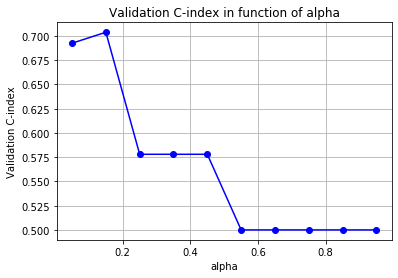

In [38]:
plt.figure()
plt.plot(lst_alphas, lst_cindex ,'b-o')
plt.grid()
plt.xlabel("alpha")
plt.ylabel("Validation C-index")
plt.title("Validation C-index in function of alpha")
plt.show()

In [47]:
lst_cindex

[0.6925395629186697,
 0.7038432554581474,
 0.5779954785186285,
 0.5779954785186285,
 0.5779954785186285,
 0.4999999999962321,
 0.4999999999962321,
 0.4999999999962321,
 0.4999999999962321,
 0.4999999999962321]

In [48]:
b = lst_b[np.argmax(lst_cindex)]
print(np.round(b,2))

[ 0.    0.   -0.06  0.   -0.   -0.    0.36 -0.03]


In [49]:
df_X_train.columns[((b>1e-6) | (b<-1e-6))]

Index(['original_shape_Maximum3DDiameter', 'SourceDataset', 'Nstage'], dtype='object')